In [1]:

import sys
sys.path.append("..")
from models import BertForSequenceClassification

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import transformers

from sklearn.metrics import precision_score,recall_score,f1_score


import os
import collections
import datetime
import random
import string
from functools import partial
import math

/home/newdisk/jxh/anaconda/envs/sft2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
transformer_name = '../base/finbert'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
## usage：
# tokenizer("hello world!")
# tokenizer.tokenize("hello world!")
# tokenizer.encode("hello world!")
# tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

In [4]:
dataset = datasets.load_dataset("../data/finan_news_senti_data", split=["train", "test"])
dataset[0][0]

Repo card metadata block was not found. Setting CardData to empty.


{'Unnamed: 0': 0,
 '日期': '2019年2月14日',
 '公司': '盛运环保',
 '代码': 300090,
 '正负面': 0,
 '标题': '盛运环保：37.48亿元到期债务未清偿',
 '正文': '盛运环保2月13日晚间发布公告称，截至目前，共有37.48亿元到期债务未清偿。'}

In [5]:
# 筛选
# dataset = [part_data.filter(lambda example: example["task"]=="FINFE" and ("积极" in example["output"] or "消极" in example["output"]) for part_data in dataset]

# input生成
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["正文"], truncation=True)["input_ids"]
    return {"ids": ids, "label": example['正负面']}

train_data = dataset[0].map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = dataset[1].map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map: 100%|██████████| 2400/2400 [00:01<00:00, 1786.76 examples/s]


In [6]:
pad_index = tokenizer.pad_token_id

In [7]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [8]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [9]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [10]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [11]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [12]:
# class Transformer(nn.Module):
#     def __init__(self, transformer, output_dim, freeze):
#         super().__init__()
#         self.transformer = transformer
#         hidden_dim = transformer.config.hidden_size
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         if freeze:
#             for param in self.transformer.parameters():
#                 param.requires_grad = False

#     def forward(self, ids, attention_mask=None):
#         # ids = [batch size, seq len]
#         output = self.transformer(ids, output_attentions=False, attention_mask = attention_mask)
#         hidden = output.last_hidden_state
#         # hidden = [batch size, seq len, hidden dim]
#         # attention = output.attentions[-1]
#         # attention = [batch size, n heads, seq len, seq len]
#         cls_hidden = hidden[:, 0, :]
#         prediction = self.fc(torch.tanh(cls_hidden))
#         # prediction = [batch size, output dim]
#         return prediction

In [14]:
output_dim = 2
freeze = True
transformer = transformers.AutoModel.from_pretrained(transformer_name)
model = BertForSequenceClassification(transformer, output_dim, freeze)

In [16]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,538 trainable parameters


In [15]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = (ids != pad_index).float().to(device)  # 生成attention_mask
        # print(ids.shape,attention_mask.shape)
        prediction = model(ids,attention_mask=attention_mask)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [16]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = (ids != pad_index).float().to(device)  # 生成attention_mask
            prediction = model(ids,attention_mask=attention_mask)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(torch.argmax(prediction, dim=1).cpu().numpy())
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return np.mean(epoch_losses), np.mean(epoch_accs), f1

In [17]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [18]:
def save_checkpoints(model,path,file_name,uid):
    torch.save(model.state_dict(), os.path.join(path,uid+"_"+file_name))

In [19]:
# 超参数    
criterion = nn.CrossEntropyLoss()   # nn.CrossEntropyLoss()  nn.MSELoss() 
lr = 3e-5
optimizer = optim.AdamW(model.parameters(), lr=lr)
## warm up + 余弦退火
cos_epochs = 65
warmup_epochs = 5
n_epochs = cos_epochs + warmup_epochs
def LR_rule(epoch,max_lr,min_lr,warmup_epochs,cos_epochs):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs 
    else:
        x = epoch-warmup_epochs
        A = (1 - min_lr/max_lr)/2
        bias = (1 + min_lr/max_lr)/2
        return  A*math.cos(x/cos_epochs*math.pi)+bias
scheduler = torch.optim.lr_scheduler.LambdaLR(
                    optimizer,
                    lr_lambda=partial(LR_rule,max_lr=lr,min_lr=1e-5,warmup_epochs=warmup_epochs,cos_epochs=cos_epochs),
                    last_epoch=-1
            )

# info cache
metrics = collections.defaultdict(list) 
best_valid_loss = float("inf") 
uid = datetime.datetime.now().strftime('%y%m%d_%H%M')  # 获取当前的年月日时分，只保留年份的最后两位

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [21]:
for epoch in range(n_epochs):
    # 更新学习率
    try:
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
    except NameError:
        pass

    train_loss, train_acc = train(train_data_loader, model, criterion, optimizer, device)
    valid_loss, valid_acc, f1 = evaluate(valid_data_loader, model, criterion, device)

    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["f1_score"].append(f1)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoints(model,"../outputs","bert_sentiment.pt",uid)
    print(f"epoch: {epoch}")
    print(f"Current learning rate: {current_lr}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
    print(f"valid_f1: {f1:.3f}")

evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.35it/s]


epoch: 0
Current learning rate: 6e-06
train_loss: 0.693, train_acc: 0.531
valid_loss: 0.664, valid_acc: 0.622
valid_f1: 0.621


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.14it/s]


epoch: 1
Current learning rate: 1.2e-05
train_loss: 0.645, train_acc: 0.663
valid_loss: 0.602, valid_acc: 0.760
valid_f1: 0.760


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.03it/s]


epoch: 2
Current learning rate: 1.8e-05
train_loss: 0.587, train_acc: 0.755
valid_loss: 0.541, valid_acc: 0.793
valid_f1: 0.794


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 3
Current learning rate: 2.4e-05
train_loss: 0.535, train_acc: 0.784
valid_loss: 0.492, valid_acc: 0.815
valid_f1: 0.815


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.04it/s]


epoch: 4
Current learning rate: 3e-05
train_loss: 0.493, train_acc: 0.800
valid_loss: 0.454, valid_acc: 0.831
valid_f1: 0.832


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 5
Current learning rate: 2.998832226832327e-05
train_loss: 0.464, train_acc: 0.815
valid_loss: 0.429, valid_acc: 0.840
valid_f1: 0.841


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 6
Current learning rate: 2.9953316347176488e-05
train_loss: 0.443, train_acc: 0.820
valid_loss: 0.413, valid_acc: 0.842
valid_f1: 0.843


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.05it/s]


epoch: 7
Current learning rate: 2.9895063994510514e-05
train_loss: 0.430, train_acc: 0.827
valid_loss: 0.399, valid_acc: 0.852
valid_f1: 0.853


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 8
Current learning rate: 2.9813701261394135e-05
train_loss: 0.421, train_acc: 0.829
valid_loss: 0.390, valid_acc: 0.856
valid_f1: 0.856


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 9
Current learning rate: 2.970941817426052e-05
train_loss: 0.409, train_acc: 0.835
valid_loss: 0.382, valid_acc: 0.858
valid_f1: 0.859


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 10
Current learning rate: 2.9582458291091663e-05
train_loss: 0.403, train_acc: 0.834
valid_loss: 0.374, valid_acc: 0.861
valid_f1: 0.861


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 11
Current learning rate: 2.9433118132577435e-05
train_loss: 0.401, train_acc: 0.832
valid_loss: 0.369, valid_acc: 0.862
valid_f1: 0.863


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.04it/s]


epoch: 12
Current learning rate: 2.9261746489577766e-05
train_loss: 0.390, train_acc: 0.843
valid_loss: 0.364, valid_acc: 0.866
valid_f1: 0.866


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.05it/s]


epoch: 13
Current learning rate: 2.9068743608505453e-05
train_loss: 0.389, train_acc: 0.843
valid_loss: 0.360, valid_acc: 0.865
valid_f1: 0.865


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 14
Current learning rate: 2.88545602565321e-05
train_loss: 0.386, train_acc: 0.844
valid_loss: 0.356, valid_acc: 0.867
valid_f1: 0.867


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 15
Current learning rate: 2.8619696668800494e-05
train_loss: 0.381, train_acc: 0.843
valid_loss: 0.352, valid_acc: 0.868
valid_f1: 0.869


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 16
Current learning rate: 2.836470138010227e-05
train_loss: 0.380, train_acc: 0.844
valid_loss: 0.350, valid_acc: 0.869
valid_f1: 0.869


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 17
Current learning rate: 2.8090169943749476e-05
train_loss: 0.375, train_acc: 0.847
valid_loss: 0.347, valid_acc: 0.870
valid_f1: 0.871


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 18
Current learning rate: 2.7796743540632228e-05
train_loss: 0.369, train_acc: 0.850
valid_loss: 0.344, valid_acc: 0.869
valid_f1: 0.869


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 19
Current learning rate: 2.7485107481711013e-05
train_loss: 0.369, train_acc: 0.847
valid_loss: 0.342, valid_acc: 0.873
valid_f1: 0.874


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.05it/s]


epoch: 20
Current learning rate: 2.7155989607441213e-05
train_loss: 0.369, train_acc: 0.847
valid_loss: 0.339, valid_acc: 0.874
valid_f1: 0.874


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 21
Current learning rate: 2.6810158587867972e-05
train_loss: 0.366, train_acc: 0.846
valid_loss: 0.337, valid_acc: 0.874
valid_f1: 0.874


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 22
Current learning rate: 2.6448422127361706e-05
train_loss: 0.363, train_acc: 0.852
valid_loss: 0.336, valid_acc: 0.876
valid_f1: 0.875


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 23
Current learning rate: 2.6071625078187116e-05
train_loss: 0.362, train_acc: 0.855
valid_loss: 0.334, valid_acc: 0.874
valid_f1: 0.874


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 24
Current learning rate: 2.568064746731156e-05
train_loss: 0.359, train_acc: 0.854
valid_loss: 0.333, valid_acc: 0.873
valid_f1: 0.874


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.04it/s]


epoch: 25
Current learning rate: 2.527640244106133e-05
train_loss: 0.361, train_acc: 0.851
valid_loss: 0.331, valid_acc: 0.877
valid_f1: 0.877


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 26
Current learning rate: 2.4859834132426064e-05
train_loss: 0.361, train_acc: 0.850
valid_loss: 0.329, valid_acc: 0.876
valid_f1: 0.876


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 27
Current learning rate: 2.4431915455992415e-05
train_loss: 0.359, train_acc: 0.851
valid_loss: 0.328, valid_acc: 0.877
valid_f1: 0.877


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 28
Current learning rate: 2.3993645835656956e-05
train_loss: 0.356, train_acc: 0.851
valid_loss: 0.327, valid_acc: 0.876
valid_f1: 0.876


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 29
Current learning rate: 2.3546048870425357e-05
train_loss: 0.357, train_acc: 0.851
valid_loss: 0.326, valid_acc: 0.879
valid_f1: 0.879


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 30
Current learning rate: 2.309016994374948e-05
train_loss: 0.355, train_acc: 0.856
valid_loss: 0.325, valid_acc: 0.878
valid_f1: 0.877


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 31
Current learning rate: 2.262707378198587e-05
train_loss: 0.351, train_acc: 0.855
valid_loss: 0.324, valid_acc: 0.879
valid_f1: 0.879


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 32
Current learning rate: 2.2157841967678064e-05
train_loss: 0.352, train_acc: 0.855
valid_loss: 0.323, valid_acc: 0.879
valid_f1: 0.879


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 33
Current learning rate: 2.168357041347039e-05
train_loss: 0.351, train_acc: 0.857
valid_loss: 0.322, valid_acc: 0.881
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 34
Current learning rate: 2.1205366802553234e-05
train_loss: 0.349, train_acc: 0.859
valid_loss: 0.321, valid_acc: 0.881
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 35
Current learning rate: 2.0724348001617625e-05
train_loss: 0.349, train_acc: 0.857
valid_loss: 0.321, valid_acc: 0.881
valid_f1: 0.881


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 36
Current learning rate: 2.0241637452361324e-05
train_loss: 0.350, train_acc: 0.854
valid_loss: 0.320, valid_acc: 0.882
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 37
Current learning rate: 1.9758362547638683e-05
train_loss: 0.347, train_acc: 0.858
valid_loss: 0.319, valid_acc: 0.882
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 38
Current learning rate: 1.9275651998382378e-05
train_loss: 0.348, train_acc: 0.860
valid_loss: 0.319, valid_acc: 0.883
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 39
Current learning rate: 1.8794633197446773e-05
train_loss: 0.348, train_acc: 0.860
valid_loss: 0.318, valid_acc: 0.882
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.04it/s]


epoch: 40
Current learning rate: 1.8316429586529617e-05
train_loss: 0.347, train_acc: 0.857
valid_loss: 0.317, valid_acc: 0.883
valid_f1: 0.882


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.03it/s]


epoch: 41
Current learning rate: 1.7842158032321942e-05
train_loss: 0.343, train_acc: 0.861
valid_loss: 0.317, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.04it/s]


epoch: 42
Current learning rate: 1.7372926218014136e-05
train_loss: 0.348, train_acc: 0.857
valid_loss: 0.317, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.04it/s]


epoch: 43
Current learning rate: 1.690983005625053e-05
train_loss: 0.345, train_acc: 0.857
valid_loss: 0.316, valid_acc: 0.884
valid_f1: 0.884


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 44
Current learning rate: 1.6453951129574646e-05
train_loss: 0.345, train_acc: 0.856
valid_loss: 0.315, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 45
Current learning rate: 1.6006354164343047e-05
train_loss: 0.347, train_acc: 0.854
valid_loss: 0.315, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 46
Current learning rate: 1.5568084544007592e-05
train_loss: 0.339, train_acc: 0.861
valid_loss: 0.314, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 47
Current learning rate: 1.514016586757394e-05
train_loss: 0.346, train_acc: 0.857
valid_loss: 0.314, valid_acc: 0.883
valid_f1: 0.883


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.11it/s]


epoch: 48
Current learning rate: 1.4723597558938676e-05
train_loss: 0.346, train_acc: 0.862
valid_loss: 0.314, valid_acc: 0.885
valid_f1: 0.884


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 49
Current learning rate: 1.4319352532688447e-05
train_loss: 0.345, train_acc: 0.860
valid_loss: 0.313, valid_acc: 0.884
valid_f1: 0.884


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 50
Current learning rate: 1.3928374921812891e-05
train_loss: 0.340, train_acc: 0.864
valid_loss: 0.313, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 51
Current learning rate: 1.3551577872638299e-05
train_loss: 0.338, train_acc: 0.862
valid_loss: 0.312, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 52
Current learning rate: 1.318984141213203e-05
train_loss: 0.341, train_acc: 0.859
valid_loss: 0.312, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.12it/s]


epoch: 53
Current learning rate: 1.2844010392558793e-05
train_loss: 0.343, train_acc: 0.860
valid_loss: 0.312, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 54
Current learning rate: 1.2514892518288992e-05
train_loss: 0.343, train_acc: 0.859
valid_loss: 0.312, valid_acc: 0.884
valid_f1: 0.884


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 55
Current learning rate: 1.220325645936778e-05
train_loss: 0.334, train_acc: 0.862
valid_loss: 0.311, valid_acc: 0.886
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 56
Current learning rate: 1.1909830056250529e-05
train_loss: 0.341, train_acc: 0.862
valid_loss: 0.311, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 57
Current learning rate: 1.1635298619897735e-05
train_loss: 0.339, train_acc: 0.861
valid_loss: 0.311, valid_acc: 0.886
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 58
Current learning rate: 1.1380303331199511e-05
train_loss: 0.340, train_acc: 0.859
valid_loss: 0.310, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 59
Current learning rate: 1.1145439743467904e-05
train_loss: 0.343, train_acc: 0.857
valid_loss: 0.310, valid_acc: 0.886
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 60
Current learning rate: 1.0931256391494548e-05
train_loss: 0.339, train_acc: 0.861
valid_loss: 0.310, valid_acc: 0.884
valid_f1: 0.884


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.10it/s]


epoch: 61
Current learning rate: 1.073825351042224e-05
train_loss: 0.335, train_acc: 0.860
valid_loss: 0.310, valid_acc: 0.887
valid_f1: 0.887


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 62
Current learning rate: 1.0566881867422572e-05
train_loss: 0.337, train_acc: 0.862
valid_loss: 0.309, valid_acc: 0.887
valid_f1: 0.887


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 63
Current learning rate: 1.041754170890834e-05
train_loss: 0.340, train_acc: 0.862
valid_loss: 0.309, valid_acc: 0.887
valid_f1: 0.887


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.07it/s]


epoch: 64
Current learning rate: 1.0290581825739483e-05
train_loss: 0.333, train_acc: 0.860
valid_loss: 0.309, valid_acc: 0.887
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.09it/s]


epoch: 65
Current learning rate: 1.0186298738605868e-05
train_loss: 0.342, train_acc: 0.859
valid_loss: 0.309, valid_acc: 0.888
valid_f1: 0.888


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]


epoch: 66
Current learning rate: 1.0104936005489492e-05
train_loss: 0.335, train_acc: 0.861
valid_loss: 0.309, valid_acc: 0.885
valid_f1: 0.885


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 67
Current learning rate: 1.0046683652823517e-05
train_loss: 0.336, train_acc: 0.861
valid_loss: 0.308, valid_acc: 0.886
valid_f1: 0.886


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.06it/s]


epoch: 68
Current learning rate: 1.0011677731676736e-05
train_loss: 0.336, train_acc: 0.863
valid_loss: 0.308, valid_acc: 0.888
valid_f1: 0.888


evaluating...: 100%|██████████| 430/430 [00:16<00:00, 26.08it/s]

epoch: 69
Current learning rate: 1.0000000000000003e-05
train_loss: 0.336, train_acc: 0.862
valid_loss: 0.308, valid_acc: 0.886
valid_f1: 0.886


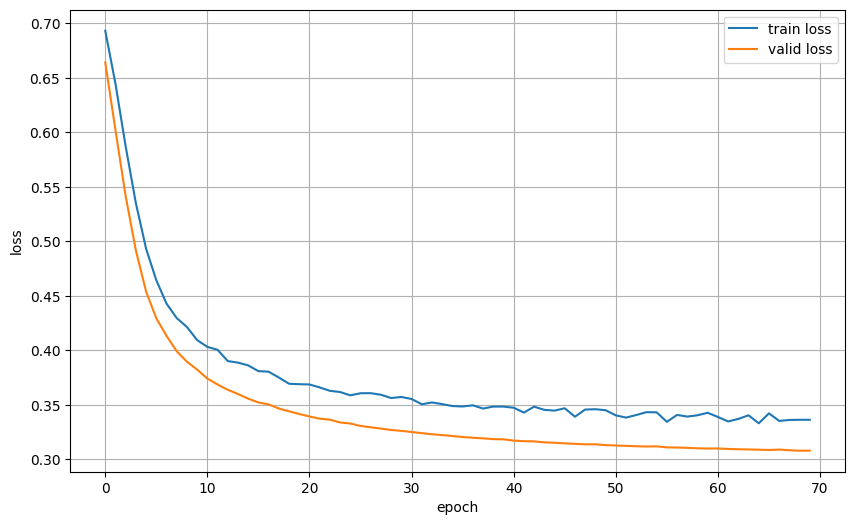

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

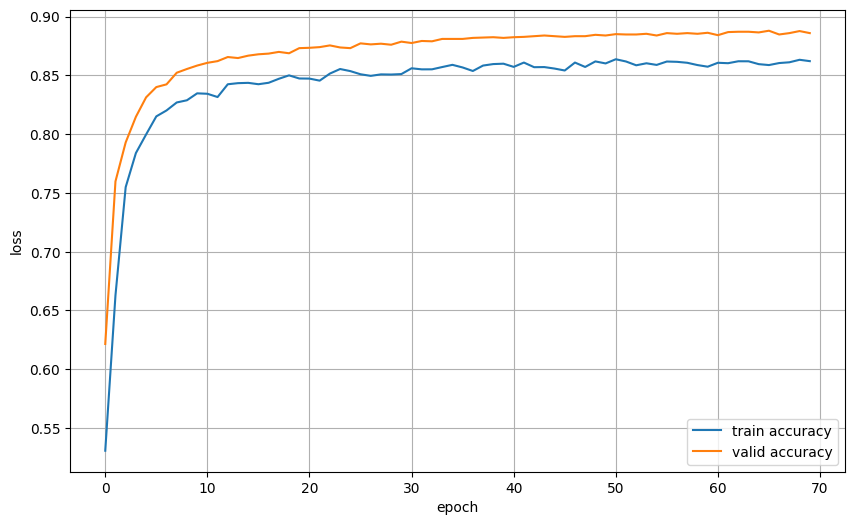

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [24]:
# model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc, test_f1 = evaluate(test_data_loader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}, test_f1: {test_f1:.3f}")

evaluating...: 100%|██████████| 300/300 [00:11<00:00, 26.00it/s]

test_loss: 0.283, test_acc: 0.898, test_f1: 0.898


In [25]:
def predict_sentiment(text, model, tokenizer, device):
    ids= tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [26]:
text = "迪威迅股权质押违约 控股股东或被动减持"
# text = "银行股全线飘绿 平安银行跌4%"

predict_sentiment(text, model, tokenizer, device)

(0, 0.8883987069129944)

In [27]:
text = "平安银行理财子公司获批筹建：注册资本50亿 股份行第五家"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9766350984573364)